평가문항	상세기준

1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?	
> 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.

2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?	
> 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.

3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?
> 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.

In [1]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [2]:
import time
import re
import os
import io
import random
import logging
import math

from tqdm import tqdm
# from tqdm.notebook import tqdm

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import pandas as pd
import numpy as np

import tensorflow as tf
import sentencepiece as spm

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Step 1. 데이터 다운로드

읽어 온 데이터의 질문과 답변을 각각 questions, answers 변수에 나눠서 저장하세요!

In [4]:
df = pd.read_csv("./data/ChatbotData.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [21]:
questions = df["Q"]
answers = df["A"]

In [22]:
questions[0]

'12시 땡!'

In [23]:
answers[0]

'하루가 또 가네요.'

# Step 2. 데이터 정제

아래 조건을 만족하는 preprocess_sentence() 함수를 구현하세요.

- 영문자의 경우, 모두 소문자로 변환합니다.
- 영문자와 한글, 숫자, 그리고 주요 특수문자를 제외하곤 정규식을 활용하여 모두 제거합니다.

문장부호 양옆에 공백을 추가하는 등 이전과 다르게 생략된 기능들은 우리가 사용할 토크나이저가 지원하기 때문에 굳이 구현하지 않아도 괜찮습니다!

In [3]:
class TextCleaner:
    def __init__(self):
        self.punct_space_re = re.compile(r"([?.!,])")
        self.multiple_spaces_re = re.compile(r'[" "]+')
        self.allowed_chars_re = re.compile(r"[^a-zA-Z가-힣?.!,]+")
        self.email_re = re.compile(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)')
        self.url_re = re.compile(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
        self.korean_chars_re = re.compile(r'([ㄱ-ㅎㅏ-ㅣ]+)')
        self.html_tag_re = re.compile(r'<[^>]*>')
        self.special_chars_re = re.compile(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]')
        
    def clean_text(self, text):
        try:
            text = text.strip().lower()
            text = self.punct_space_re.sub(r" \1 ", text)
            text = self.multiple_spaces_re.sub(" ", text)
            text = self.allowed_chars_re.sub(" ", text)
            text = self.email_re.sub("", text)
            text = self.url_re.sub("", text)
            text = self.korean_chars_re.sub("", text)
            text = self.html_tag_re.sub("", text)
            text = self.special_chars_re.sub("", text)
            text = text.replace('\n', '.')
            return text
        except TypeError:
            print("Warning: Input was not a string or bytes-like object.")
            print(text)
            return text

    # 데이터 정제
    def clean_corpus(self, corpus):
        
        self.corpus_cleaned = []
        
        for sentence in corpus:
            self.corpus_cleaned.append(self.clean_text(sentence))
    
        return self.corpus_cleaned

    # get unique data for the corpus1 
    def get_unique_corpus1(self, corpus1, corpus2):
        seen_sentences = set()
        unique_corpus1 = []
        unique_corpus2 = []
        original_length = len(corpus1)
        for sent1, sent2 in zip(corpus1, corpus2):
            sent1_str = ' '.join(sent1)
            if sent1_str not in seen_sentences:
                seen_sentences.add(sent1_str)
                unique_corpus1.append(sent1)
                unique_corpus2.append(sent2)
        removed_length = original_length - len(unique_corpus1)
        print(f"removed: {removed_length}")
        return [unique_corpus1, unique_corpus2]


    # get unique data for the corpus1,2
    def get_unique_corpus_both(self, corpus):

        self.unique_corpus = self.get_unique_corpus1(corpus[1], corpus[0])  # for corpus2.
        self.unique_corpus = self.get_unique_corpus1(self.unique_corpus[1], self.unique_corpus[0])  # for corpus1.
    
        return self.unique_corpus

In [4]:
cleaner = TextCleaner()

In [68]:
tmp = cleaner.clean_corpus(df["Q"].iloc[:3])
print(tmp)

[' 시 땡  ', ' 지망 학교 떨어졌어', ' 박 일 놀러가고 싶다']


In [64]:
df["Q_cleaned"] = cleaner.clean_corpus(df["Q"])
df["A_cleaned"] = cleaner.clean_corpus(df["A"])

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Q          11823 non-null  object
 1   A          11823 non-null  object
 2   label      11823 non-null  int64 
 3   Q_cleaned  11823 non-null  object
 4   A_cleaned  11823 non-null  object
dtypes: int64(1), object(4)
memory usage: 462.0+ KB


In [66]:
df.head(3)

,Q,A,label,Q_cleaned,A_cleaned
0,12시 땡!,하루가 또 가네요.,0,시 땡,하루가 또 가네요
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박 일 놀러가고 싶다,여행은 언제나 좋죠


# Step 3. 데이터 토큰화

토큰화에는 KoNLPy의 mecab 클래스를 사용합니다.  
아래 조건을 만족하는 build_corpus() 함수를 구현하세요!  

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

구현한 함수를 활용하여 questions 와 answers 를 각각 que_corpus , ans_corpus 에 토큰화하여 저장합니다.

In [5]:
from konlpy.tag import Mecab

mecab = Mecab()

In [70]:
res = mecab.morphs(tmp[0])
print(res)

['시', '땡']


In [6]:
def get_tokenized_sentence(sentence, tokenizer):
    return tokenizer.morphs(sentence)

In [7]:
def get_tokenized_corpus(corpus, tokenizer):
    corpus_tokenized = []
    for sentence in corpus:
        corpus_tokenized.append(get_tokenized_sentence(sentence, tokenizer))
    return corpus_tokenized

In [57]:
df["Q_tokenized"] = get_tokenized_corpus(df["Q_cleaned"], mecab)
df["A_tokenized"] = get_tokenized_corpus(df["A_cleaned"], mecab)

In [58]:
df.loc[:, "Q_length"] = df["Q_tokenized"].apply(lambda x: len(x))
df.loc[:, "A_length"] = df["A_tokenized"].apply(lambda x: len(x))

In [59]:
df.head(3)

,Q,A,label,Q_cleaned,A_cleaned,Q_tokenized,A_tokenized,Q_length,A_length
0,12시 땡!,하루가 또 가네요.,0,시 땡,하루가 또 가네요,"[시, 땡]","[하루, 가, 또, 가, 네요]",2,5
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다,"[지망, 학교, 떨어졌, 어]","[위로, 해, 드립니다]",4,3
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박 일 놀러가고 싶다,여행은 언제나 좋죠,"[박, 일, 놀, 러, 가, 고, 싶, 다]","[여행, 은, 언제나, 좋, 죠]",8,5


<AxesSubplot:>

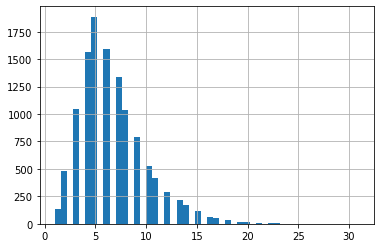

In [138]:
df["Q_length"].hist(bins=50)

<AxesSubplot:>

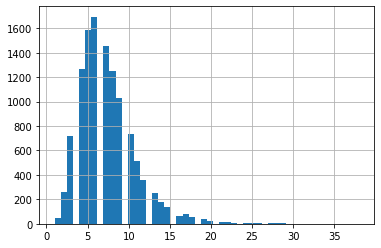

In [139]:
df["A_length"].hist(bins=50)

In [60]:
df_org = df.copy()

In [132]:
df = df_org.copy()

In [61]:
df = df[df["Q_length"] < 20]
df = df[df["A_length"] < 20]

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11687 entries, 0 to 11686
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Q            11687 non-null  object
 1   A            11687 non-null  object
 2   label        11687 non-null  int64 
 3   Q_cleaned    11687 non-null  object
 4   A_cleaned    11687 non-null  object
 5   Q_tokenized  11687 non-null  object
 6   A_tokenized  11687 non-null  object
 7   Q_length     11687 non-null  int64 
 8   A_length     11687 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 913.0+ KB


<AxesSubplot:>

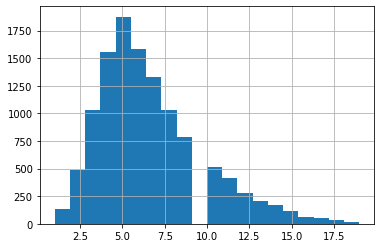

In [63]:
df["Q_length"].hist(bins=20)

<AxesSubplot:>

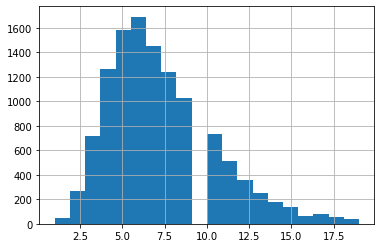

In [64]:
df["A_length"].hist(bins=20)

In [65]:
df.head(10)

,Q,A,label,Q_cleaned,A_cleaned,Q_tokenized,A_tokenized,Q_length,A_length
0,12시 땡!,하루가 또 가네요.,0,시 땡,하루가 또 가네요,"[시, 땡]","[하루, 가, 또, 가, 네요]",2,5
1,1지망 학교 떨어졌어,위로해 드립니다.,0,지망 학교 떨어졌어,위로해 드립니다,"[지망, 학교, 떨어졌, 어]","[위로, 해, 드립니다]",4,3
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,박 일 놀러가고 싶다,여행은 언제나 좋죠,"[박, 일, 놀, 러, 가, 고, 싶, 다]","[여행, 은, 언제나, 좋, 죠]",8,5
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,박 일 정도 놀러가고 싶다,여행은 언제나 좋죠,"[박, 일, 정도, 놀, 러, 가, 고, 싶, 다]","[여행, 은, 언제나, 좋, 죠]",9,5
4,PPL 심하네,눈살이 찌푸려지죠.,0,ppl 심하네,눈살이 찌푸려지죠,"[ppl, 심하, 네]","[눈살, 이, 찌푸려, 지, 죠]",3,5
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0,sd카드 망가졌어,다시 새로 사는 게 마음 편해요,"[sd, 카드, 망가졌, 어]","[다시, 새로, 사, 는, 게, 마음, 편해요]",4,7
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0,sd카드 안돼,다시 새로 사는 게 마음 편해요,"[sd, 카드, 안, 돼]","[다시, 새로, 사, 는, 게, 마음, 편해요]",4,7
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요,"[sns, 맞, 팔, 왜, 안, 하, 지]","[잘, 모르, 고, 있, 을, 수, 도, 있, 어요]",7,9
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요,"[sns, 시간, 낭비, 인, 거, 아, 는데, 매일, 하, 는, 중]","[시간, 을, 정하, 고, 해, 보, 세요]",11,7
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요,"[sns, 시간, 낭비, 인데, 자꾸, 보, 게, 됨]","[시간, 을, 정하, 고, 해, 보, 세요]",8,7


In [66]:
df.to_csv("df.csv", index=False)

In [67]:
save_var(df, "df")

In [50]:
df = load_var("df")

In [54]:
df = pd.read_csv("df.csv")

In [68]:
questions = df["Q_tokenized"]
answers = df["A_tokenized"]

# Step 4. Augmentation

우리에게 주어진 데이터는 1만 개가량으로 적은 편에 속합니다.   
이럴 때에 사용할 수 있는 테크닉을 배웠으니 활용해 봐야겠죠?   
Lexical Substitution을 실제로 적용해 보도록 하겠습니다.  

아래 링크를 참고하여 한국어로 사전 훈련된 Embedding 모델을 다운로드합니다.   
Korean (w) 가 Word2Vec으로 학습한 모델이며 용량도 적당하므로 사이트에서 Korean (w)를 찾아 다운로드하고, ko.bin 파일을 얻으세요!  

Kyubyong/wordvectors  

다운로드한 모델을 활용해 데이터를 Augmentation 하세요! 앞서 정의한 lexical_sub() 함수를 참고하면 도움이 많이 될 겁니다.  

Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록,   
이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.  

In [10]:
from gensim.models import Word2Vec

In [11]:
wv = Word2Vec.load("./data/word2vec_ko.model")

In [12]:
def lexical_sub(sentence, wv, sentence_num=2):
    sentences = []
    for _ in range(sentence_num):
        sentences.append(" ".join(sentence).split())
    
    if not sentences[0]: return None
    
    indices = list(range(len(sentences[0])))
    random.shuffle(indices)
    unique_indices = indices[:sentence_num]

    for i, index in enumerate(unique_indices):
        word = sentences[i][index]
        if word in wv:
            similar_word = wv.most_similar(word)
            if not similar_word:
                return None

            word_sub = similar_word[0][0]
            sentences[i][index] = word_sub
    
    return sentences

In [13]:
from tqdm.notebook import tqdm

In [69]:
corpus_aug = []
count_none = 0

for que, ans in tqdm(zip(questions, answers), total=len(questions)):
    corpus_aug.append((que, ans))
    sentences = lexical_sub(que, wv.wv, sentence_num=2)
    for sentence in sentences:
        if sentence is not None: 
            corpus_aug.append((sentence, ans))

  0%|          | 0/11687 [00:00<?, ?it/s]

In [70]:
print(len(corpus_aug))
for index, sentence in enumerate(corpus_aug):
    print(f"{index:2}", sentence[0])
    if index > 10: break

35061
 0 ['시', '땡']
 1 ['시', '돌이']
 2 ['시경', '땡']
 3 ['지망', '학교', '떨어졌', '어']
 4 ['지망', '학교', '올라갔', '어']
 5 ['지망', '학교', '떨어졌', '어서']
 6 ['박', '일', '놀', '러', '가', '고', '싶', '다']
 7 ['김', '일', '놀', '러', '가', '고', '싶', '다']
 8 ['박', '일', '울', '러', '가', '고', '싶', '다']
 9 ['박', '일', '정도', '놀', '러', '가', '고', '싶', '다']
10 ['박', '일', '정도', '울', '러', '가', '고', '싶', '다']
11 ['박', '일', '만큼', '놀', '러', '가', '고', '싶', '다']


In [71]:
save_var(corpus_aug, "corpus_aug_x3")

In [72]:
corpus_aug = load_var("corpus_aug_x3")

# Step 5. 데이터 벡터화

In [6]:
sample_data = ["12", "시", "땡", "!"]

print(["<start>"] + sample_data + ["<end>"])

['<start>', '12', '시', '땡', '!', '<end>']


1. 위 소스를 참고하여 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가해 주세요!   

챗봇 훈련 데이터의 가장 큰 특징 중 하나라고 하자면 바로 소스 데이터와 타겟 데이터가 같은 언어를 사용한다는 것이겠죠.  
앞서 배운 것처럼 이는 Embedding 층을 공유했을 때 많은 이점을 얻을 수 있습니다.  

2. 특수 토큰을 더함으로써 ans_corpus 또한 완성이 되었으니, que_corpus 와 결합하여 전체 데이터에 대한 단어 사전을 구축하고 벡터화하여 enc_train 과 dec_train 을 얻으세요!  

In [73]:
que_corpus, ans_corpus = zip(*corpus_aug)

In [74]:
df_corpus = pd.DataFrame({'questions': que_corpus, 'answers': ans_corpus})

In [75]:
df_corpus["questions"] = df_corpus["questions"].apply(tuple)

In [76]:
df_corpus.head(3)

,questions,answers
0,"(시, 땡)","[하루, 가, 또, 가, 네요]"
1,"(시, 돌이)","[하루, 가, 또, 가, 네요]"
2,"(시경, 땡)","[하루, 가, 또, 가, 네요]"


In [77]:
df_corpus = df_corpus.drop_duplicates(subset="questions", keep="first")

In [78]:
df_corpus_copy = df_corpus.copy()
df_corpus_copy["questions"] = df_corpus_copy["questions"].apply(list)
df_corpus = df_corpus.copy()

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [79]:
df_corpus_copy = df_corpus.copy()
df_corpus_copy["target_tokens"] = [["<start>"] + s + ["<end>"] for s in df_corpus_copy["answers"]]
df_corpus = df_corpus_copy.copy()

In [84]:
df_corpus["questions"] = df_corpus["questions"].apply(list)

In [85]:
df_corpus.head(3)

,questions,answers,target_tokens
0,"[시, 땡]","[하루, 가, 또, 가, 네요]","[<start>, 하루, 가, 또, 가, 네요, <end>]"
1,"[시, 돌이]","[하루, 가, 또, 가, 네요]","[<start>, 하루, 가, 또, 가, 네요, <end>]"
2,"[시경, 땡]","[하루, 가, 또, 가, 네요]","[<start>, 하루, 가, 또, 가, 네요, <end>]"


In [86]:
df_corpus.to_csv("df_corpus_x3.csv", index=False)

In [18]:
df_corpus = pd.read_csv("df_corpus_x3.csv")

In [87]:
save_var(df_corpus, "df_corpus_x3")

In [16]:
df_corpus = load_var("df_corpus_x3")

In [88]:
total_corpus = df_corpus["questions"].to_list() + df_corpus["target_tokens"].to_list()

tokenizer = Tokenizer(filters="", lower=False, oov_token="<unk>")
tokenizer.fit_on_texts(total_corpus)

In [89]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8552

In [90]:
que_seqs = tokenizer.texts_to_sequences(df_corpus["questions"])
ans_seqs = tokenizer.texts_to_sequences(df_corpus["target_tokens"])

enc_train = pad_sequences(que_seqs, padding="post")
dec_train = pad_sequences(ans_seqs, padding="post")

In [91]:
save_var(enc_train, "enc_train_x3")
save_var(dec_train, "dec_train_x3")

In [19]:
enc_train = load_var("enc_train")
dec_train = load_var("dec_train")

In [123]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size=BATCH_SIZE)

# Step 6. 훈련하기

## transformer 

In [21]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [22]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [24]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [26]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [27]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [28]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [124]:
d_model = 512

transformer = Transformer(
    n_layers=2,
    d_model=d_model,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)


In [37]:
transformer.load_weights("t1")

## LearningRateScheduler

In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

## Loss Function

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Train Step

In [125]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## Train

In [126]:
losses = []

In [127]:
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    
    for (src, tgt) in train_dataset:
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += loss
        tqdm_bar.set_description(f'Epoch {epoch + 1} Loss {total_loss.numpy():.4f}')
        tqdm_bar.update()
    tqdm_bar.close()
    losses.append(total_loss.numpy())
    print(f'Epoch {epoch + 1} Loss {total_loss.numpy():.4f}')

  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 1 Loss 1196.5056


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 2 Loss 770.8915


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 3 Loss 515.7512


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 4 Loss 332.1277


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 5 Loss 218.5047


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 6 Loss 153.2797


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 7 Loss 111.0792


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 8 Loss 87.3231


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 9 Loss 69.9488


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 10 Loss 60.6576


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 11 Loss 51.1698


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 12 Loss 46.3578


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 13 Loss 41.0188


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 14 Loss 36.5912


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 15 Loss 34.5296


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 16 Loss 31.8692


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 17 Loss 30.5557


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 18 Loss 27.7971


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 19 Loss 26.0217


  0%|          | 0/266 [00:00<?, ?it/s]

Epoch 20 Loss 24.4262


In [128]:
prefix = "t3"

In [129]:
transformer.save_weights(prefix)

In [130]:
print(losses)

[1196.5056, 770.89154, 515.7512, 332.12772, 218.50471, 153.27972, 111.07922, 87.32306, 69.94883, 60.657585, 51.169834, 46.357754, 41.018753, 36.591194, 34.529594, 31.869173, 30.55571, 27.797064, 26.021723, 24.426159]


In [99]:
histories = {}

In [131]:
histories[prefix] = losses

In [132]:
save_var(histories, "histories")

In [106]:
histories = load_var("histories")

In [133]:
print(histories)

{'t0': [3832.5205, 2699.2415, 2176.4763], 't2': [3019.052, 2088.4956, 1682.1465, 1293.043, 1016.2196, 890.7383, 821.02826, 798.14386, 676.56366, 530.8138, 422.03873, 345.6523, 292.3675, 251.544, 222.10175, 192.92442, 169.73122, 149.50732, 134.93729, 118.146194], 't3': [1196.5056, 770.89154, 515.7512, 332.12772, 218.50471, 153.27972, 111.07922, 87.32306, 69.94883, 60.657585, 51.169834, 46.357754, 41.018753, 36.591194, 34.529594, 31.869173, 30.55571, 27.797064, 26.021723, 24.426159]}


- t0: base. 3 epochs
- t1: 20 epochs
- t2: data aug. x4 --> x3
- t3: batch size. 64 --> 128

# Step 7. 성능 측정하기

주어진 질문에 적절한 답변을 하는지 확인하고, BLEU Score를 계산하는 calculate_bleu() 함수도 적용해 보세요.

```
# 예문
1. 지루하다, 놀러가고 싶어.
2. 오늘 일찍 일어났더니 피곤하다.
3. 간만에 여자친구랑 데이트 하기로 했어.
4. 집에 있는다는 소리야.

---

# 제출

Translations
> 1. 잠깐 쉬 어도 돼요 . <end>
> 2. 맛난 거 드세요 . <end>
> 3. 떨리 겠 죠 . <end>
> 4. 좋 아 하 면 그럴 수 있 어요 . <end>

Hyperparameters
> n_layers: 1
> d_model: 368
> n_heads: 8
> d_ff: 1024
> dropout: 0.2

Training Parameters
> Warmup Steps: 1000
> Batch Size: 64
> Epoch At: 10
```

In [122]:
def translate(text_tokens, model, tokenizer):
    print(f"- {text_tokens}")
    seq_tokens = tokenizer.texts_to_sequences(text_tokens)
    padded_tokens = pad_sequences(seq_tokens, padding="post")
    
    ids = []
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)   
    for i in range(vocab_size):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(padded_tokens, output)

        predictions, _, _, _ = model(padded_tokens,
                                     output,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tokenizer.word_index['<end>'] == predicted_id:
            result = ' '.join(tokenizer.sequences_to_texts([ids]))
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = ' '.join(tokenizer.sequences_to_texts([ids]))
    return result


In [120]:
def eval_bleu_single(model, src_sentence, tgt_sentence, tokenizer, verbose=True):
    
#     print(f"src: {src_sentence}")
#     print(f"tgt: {tgt_sentence}")

    reference = tgt_sentence
    candidate = translate(src_sentence, model, tokenizer).split()

    score = sentence_bleu([reference], candidate,
                          smoothing_function=SmoothingFunction().method1)

    if verbose:
        # print("Source Sentence: ", src_sentence)
        print("Model Prediction: ", " ".join(candidate))
        print("Real: ", " ".join(reference))
        print("Score: %lf\n" % score)
        
    return score

In [45]:
def eval_bleu(model, src_sentences, tgt_sentences, tokenizer, verbose=True):
    total_score = 0.0
    sample_size = len(src_sentences)
    
    for idx in tqdm(range(sample_size)):
        src = " ".join(src_sentences[idx])
        tgt = tgt_sentences[idx]
        score = eval_bleu_single(model, src, tgt, tokenizer, verbose)
        if not score: continue
        
        total_score += score
    
    print("Num of Sample:", sample_size)
    print("Total Score:", total_score / sample_size)
    
    return total_score

In [40]:
test_questions = ["지루하다, 놀러가고 싶어.",
                  "오늘 일찍 일어났더니 피곤하다.",
                  "간만에 여자친구랑 데이트 하기로 했어.",
                  "집에 있는다는 소리야."]

In [41]:
test_questions = cleaner.clean_corpus(test_questions)
test_questions = get_tokenized_corpus(test_questions, mecab)
test_questions

[['지루', '하', '다', '놀', '러', '가', '고', '싶', '어'],
 ['오늘', '일찍', '일어났', '더니', '피곤', '하', '다'],
 ['간만에', '여자', '친구', '랑', '데이트', '하', '기', '로', '했', '어'],
 ['집', '에', '있', '는다는', '소리야']]

In [44]:
random_indices = random.sample(range(0, df_corpus.shape[0] + 1), 10)
print(random_indices)

[36721, 29576, 41665, 34028, 29759, 29952, 4288, 8121, 21349, 42258]


In [163]:
for index in random_indices:
    score = eval_bleu_single(transformer, 
                             " ".join(df_corpus["questions"].iloc[index]), 
                             df_corpus["target_tokens"].iloc[index], 
                             tokenizer)

- 헤어지 고 난 뒤 애인
Source Sentence:  헤어지 고 난 뒤 애인
Model Prediction:  ['만나', '길', '바라', '요']
Real:  ['<start>', '친구', '가', '되', '기', '쉽', '지', '않', '을', '거', '예요', '<end>']
Score: 0.000000

- 소개팅 하 고 애프터 까지 왔 지만 설렘 이 있 어
Source Sentence:  소개팅 하 고 애프터 까지 왔 지만 설렘 이 있 어
Model Prediction:  ['썸', '은', '사이', '가', '는', '사이', '가', '좋', '은', '일', '이', '에요']
Real:  ['<start>', '조금', '더', '만나', '보', '고', '결정', '하', '는', '건', '어떨까', '요', '<end>']
Score: 0.015671

- 은 남자 맘 이 뭔지
Source Sentence:  은 남자 맘 이 뭔지
Model Prediction:  ['운명', '입니다']
Real:  ['<start>', '사람', '맘', '은', '알', '길', '이', '없', '어요', '<end>']
Score: 0.000000

- 나가 이 멍청 한 거 지
Source Sentence:  나가 이 멍청 한 거 지
Model Prediction:  ['운명', '은', '사람', '은', '모두', '사람', '은', '모두', '모두', '모두', '모두', '말', '은', '거', '예요']
Real:  ['<start>', '실수', '했', '나요', '<end>']
Score: 0.000000

- 년 동거 후 이별 개월 차
Source Sentence:  년 동거 후 이별 개월 차
Model Prediction:  ['많', '은', '시기', '네요']
Real:  ['<start>', '생각', '을', '오래', '하', '면', '더욱', '지칠', '수', '있', '어요', '<end

In [115]:
indices_bleu = random.sample(range(0, df_corpus.shape[0] + 1), 100)
print(indices_bleu)

[19887, 25117, 4751, 11536, 32518, 12289, 16228, 30753, 3071, 19636, 15279, 17286, 23372, 31889, 16128, 16251, 21496, 4810, 10209, 19640, 30521, 30755, 28950, 5745, 16428, 33118, 19186, 22832, 25003, 23917, 29354, 12166, 18510, 21926, 21459, 25451, 32723, 13335, 33961, 31754, 14060, 11450, 31338, 5407, 26082, 19355, 33939, 4867, 18802, 15227, 1054, 28991, 8533, 18598, 30611, 20774, 31750, 16288, 31268, 25220, 23542, 10263, 26795, 10794, 20061, 14970, 24938, 11862, 21991, 13521, 31883, 11387, 13652, 7556, 13665, 6502, 6366, 27152, 18332, 31448, 8207, 14931, 7575, 11242, 416, 23118, 21411, 7583, 1578, 21383, 2508, 9024, 11699, 24074, 15056, 25251, 12799, 8536, 540, 11955]


In [116]:
src_sentences = list(df_corpus["questions"].iloc[indices_bleu])
tgt_sentences = list(df_corpus["answers"].iloc[indices_bleu])

In [117]:
src_sentences[0], tgt_sentences[0]

(['아', '벌', '받', '고', '있', '는', '건가', '네'], ['달', '게', '받', '으세요'])

### t0

- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.3
- batch_size: 64

In [129]:
for question in test_questions:
    result = translate(" ".join(question), transformer, tokenizer)
    print(f"> {result}\n")

- 지루 하 다 놀 러 가 고 싶 어
> 고백 하 게 고백 하 세요

- 오늘 일찍 일어났 더니 피곤 하 다
> 썸 이 에요

- 간만에 여자 친구 랑 데이트 하 기 로 했 어
> 다시 시작 이 되 겠 어요

- 집 에 있 는다는 소리야
> 축하 드려요



In [178]:
score = eval_bleu(transformer, src_sentences, tgt_sentences, tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

- 오후 돌이
Source Sentence:  오후 돌이
Model Prediction:  ['썸', '이', '에요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.000000

- 오후 순이
Source Sentence:  오후 순이
Model Prediction:  ['썸', '이', '에요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.000000

- 오전 돌이
Source Sentence:  오전 돌이
Model Prediction:  ['썸', '이', '에요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.000000

- 캐스터 여학교 떨어졌 어서
Source Sentence:  캐스터 여학교 떨어졌 어서
Model Prediction:  ['사랑', '은', '언제', '든', '시작', '이', '었', '으니까요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 여학교 떨어졌 어
Source Sentence:  캐스터 여학교 떨어졌 어
Model Prediction:  ['사랑', '은', '언제', '든', '시작', '이', '었', '으니까요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 소학교 떨어졌 어서
Source Sentence:  캐스터 소학교 떨어졌 어서
Model Prediction:  ['사랑', '은', '언제', '든', '시작', '이', '었', '으니까요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 여학교 올라갔 어서
Source Sentence:  캐스터 여학교 올라갔 어서
Model Prediction:  ['사랑', '은', '언제', '든', '시작', '이', '었', '으니까요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 

### t1

- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.3
- batch_size: 64

In [189]:
for question in test_questions:
    result = translate(" ".join(question), transformer, tokenizer)
    print(f"> {result}\n")

- 지루 하 다 놀 러 가 고 싶 어
> 시기 가 다를 뿐 이 에요

- 오늘 일찍 일어났 더니 피곤 하 다
> 그 분 이 네요

- 간만에 여자 친구 랑 데이트 하 기 로 했 어
> 생각나 적 으로 도 적 되 는 게 도 적 는지 이상 할 적 이 에요

- 집 에 있 는다는 소리야
> 내 집 마련 축하 드려요



In [190]:
score = eval_bleu(transformer, src_sentences, tgt_sentences, tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

- 오후 돌이
Source Sentence:  오후 돌이
Model Prediction:  ['그', '분', '이', '네요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.062571

- 오후 순이
Source Sentence:  오후 순이
Model Prediction:  ['그', '분', '이', '네요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.062571

- 오전 돌이
Source Sentence:  오전 돌이
Model Prediction:  ['그', '분', '이', '네요']
Real:  ['하루', '가', '또', '가', '네요']
Score: 0.062571

- 캐스터 여학교 떨어졌 어서
Source Sentence:  캐스터 여학교 떨어졌 어서
Model Prediction:  ['근처', '산', '에', '가보세요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 여학교 떨어졌 어
Source Sentence:  캐스터 여학교 떨어졌 어
Model Prediction:  ['근처', '산', '에', '가보세요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 소학교 떨어졌 어서
Source Sentence:  캐스터 소학교 떨어졌 어서
Model Prediction:  ['근처', '산', '에', '가보세요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 캐스터 여학교 올라갔 어서
Source Sentence:  캐스터 여학교 올라갔 어서
Model Prediction:  ['근처', '산', '에', '가보세요']
Real:  ['위로', '해', '드립니다']
Score: 0.000000

- 윤 월 놀 러 이 는데 싶 는데
Source Sentence:  윤 월 놀 러 이 는데 싶 는데
Model Prediction:  

### t2

- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.3
- batch_size: 64

In [111]:
for question in test_questions:
    result = translate(" ".join(question), transformer, tokenizer)
    print(f"> {result}\n")

- 지루 하 다 놀 러 가 고 싶 어
> 죠

- 오늘 일찍 일어났 더니 피곤 하 다
> 따뜻 할 시기 네요

- 간만에 여자 친구 랑 데이트 하 기 로 했 어
> 헤어짐 은 헤어짐 은 헤어짐 을 좋아하 헤어짐 도 으로 습니다

- 집 에 있 는다는 소리야
> 조심히 오 세요



In [121]:
score = eval_bleu(transformer, src_sentences, tgt_sentences, tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

- 아 벌 받 고 있 는 건가 네
Model Prediction:  수십 번 어야 하나 봅니다
Real:  달 게 받 으세요
Score: 0.000000

- 헤어진지 열흘 됐 는데 연락 하 고 싶 다섯
Model Prediction:  서로 에게 부담 없 는 선물 이 좋 아요
Real:  후회 하 지 않 는다면 연락 해 보 세요
Score: 0.000000

- 머리카락 이 정말 빠져
Model Prediction:  저 도 그러 그러 그러 그러 그러 그러 그러 는 게 좋 겠 어요
Real:  스트레스 받 지 마세요
Score: 0.000000

- 자율 주행 승용차 나오 겠 지
Model Prediction:  기다리 고 말 이 기다리 고 말 고 기다리 고 기다리 고 기다리 세요
Real:  가까운 미래 에 나올 거 같 아요
Score: 0.000000

- 죽 고 못 사 는 관계
Model Prediction:  나쁜 생각 멈추 나쁜 나쁜 나쁜 생각 멈추 세요
Real:  연애 할 때 가능 하 죠
Score: 0.000000

- 졸업식 에 가 도 된 나
Model Prediction:  잠 을 깨 요 기운 내요
Real:  졸업식 에 가 서 축하 해 주 세요
Score: 0.000000

- 공허 하 네
Model Prediction:  죠
Real:  제 가 채워줄 게요
Score: 0.000000

- 여지 를 준 짝 녀 버려야 겠죠
Model Prediction:  잘 견뎌 내 상대방 이 에요
Real:  오해 가 아니 라면 정리 하 는 게 덜 상처 일 것 같 아요
Score: 0.000000

- 농사 짓 고 다른가
Model Prediction:  서로 에게 부담 없 는 선물 이 좋 아요
Real:  생각 하 기 는 쉬운데 실천 하 기 는 어려운 것 같 아요
Score: 0.018285

- 술 을 마시 러 나갈까 어디 론가 떠나 볼까
Model Prediction:  연락 이 후 에 연락 하 는 잔 하 기 좋 죠
Real:  어디 든 좋 죠


### t3

- n_layers: 2
- d_model: 512
- n_heads: 8
- d_ff: 2048
- dropout: 0.3
- batch_size: 128

In [134]:
for question in test_questions:
    result = translate(" ".join(question), transformer, tokenizer)
    print(f"> {result}\n")

- 지루 하 다 놀 러 가 고 싶 어
> 누구 에게 요

- 오늘 일찍 일어났 더니 피곤 하 다
> 기다리 고 있 나 봐요

- 간만에 여자 친구 랑 데이트 하 기 로 했 어
> 직접 적 이 든 간접 적 이 든 의사 를 확실히 밝혀 보 세요

- 집 에 있 는다는 소리야
> 그냥 신경 쓰 지 마세요



In [135]:
score = eval_bleu(transformer, src_sentences, tgt_sentences, tokenizer)

  0%|          | 0/100 [00:00<?, ?it/s]

- 아 벌 받 고 있 는 건가 네
Model Prediction:  수십 번 생각 이 수십 수십 번 마주쳐 보 세요
Real:  달 게 받 으세요
Score: 0.000000

- 헤어진지 열흘 됐 는데 연락 하 고 싶 다섯
Model Prediction:  시간 이 지나 면 좋 겠 네요
Real:  후회 하 지 않 는다면 연락 해 보 세요
Score: 0.000000

- 머리카락 이 정말 빠져
Model Prediction:  네 말씀 해 주 세요
Real:  스트레스 받 지 마세요
Score: 0.000000

- 자율 주행 승용차 나오 겠 지
Model Prediction:  기다리 고 있 었 어요
Real:  가까운 미래 에 나올 거 같 아요
Score: 0.000000

- 죽 고 못 사 는 관계
Model Prediction:  너무 무리 하 지 마세요
Real:  연애 할 때 가능 하 죠
Score: 0.043989

- 졸업식 에 가 도 된 나


InvalidArgumentError: required broadcastable shapes [Op:AddV2]

In [137]:
src_sentences[5]

['졸업식', '에', '가', '도', '된', '나']

In [138]:
res = translate(src_sentences[5], transformer, tokenizer)

- ['졸업식', '에', '가', '도', '된', '나']


In [139]:
print(res)

축하 해 주 세요
